In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

2023-06-13 16:15:06.984729: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 16:15:08.203375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
T = 128
Ntrain = 7352
Ntest = 2947
D = 9 # we have 9 files
K = 6 # number of classes

In [6]:
def load_data():
    # returns
    # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
    Xtrain = np.zeros((Ntrain, T, D))
    Xtest = np.zeros((Ntest, T, D))

    ts_filenames = [
        'body_acc_x_train.txt', 'body_gyro_x_train.txt', 'total_acc_x_train.txt', 'body_acc_y_train.txt', 'body_gyro_y_train.txt', 'total_acc_y_train.txt',
        'body_acc_z_train.txt', 'body_gyro_z_train.txt', 'total_acc_z_train.txt'
    ]

    ts_file_prefix = 'UCI-HAR/UCI-HAR-Dataset/train/'
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial-Signals/{fn}',
            header=None,
            delim_whitespace=True
        )

    x = df.to_numpy()
    Xtrain[:, :, d] = x

    Ytrain = pd.read_csv(
        f'{ts_file_prefix}y_train.txt', header=None).to_numpy() -1
    Ytrain = Ytrain.flatten()

    ts_filenames = [
        'body_acc_x_test.txt', 'body_gyro_x_test.txt', 'total_acc_test.txt',
        'body_acc_y_test.txt', 'body_gyro_y_test.txt', 'total_acc_y_test.txt',
        'body_acc_z_test.txt', 'body_gyro_z_test.txt', 'total_acc_z_test.txt'
    ]

    ts_file_prefix = 'UCI-HAR/UCI-HAR-Dataset/test/'

    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(
            f'{ts_file_prefix}Inertial-Signals/{fn}',
            header=None,
            delim_whitespace=True)

        x = df.to_numpy()
        Xtest[:, :, d] = x

        Ytest = pd.read_csv(
            f'{ts_file_prefix}y_test.txt', header=None).to_numpy() -1
        Ytest = Ytest.flatten()

        return Xtrain, Ytrain, Xtest, Ytest

In [4]:
Xtrain, Ytrain, Xtest, Ytest = load_data()

In [9]:
X_train = pd.read_csv("UCI-HAR/UCI-HAR-Dataset/train/X_train.txt", header=None).to_numpy()

In [23]:
len(Ytrain)

7352

In [5]:
Xtrain[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.1029341 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.1056872 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.1021025 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.1003852 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09987355],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09498741]])

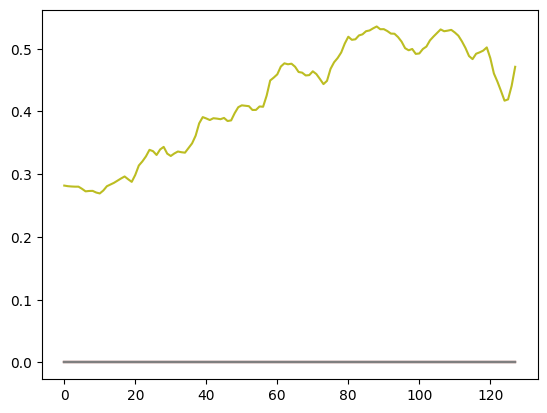

In [5]:
plt.plot(Xtrain[7000, :, :])

In [6]:
# RNN
i = Input(shape=(T, D))
x = LSTM(32, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)
model = Model(i, x)

2023-04-10 13:56:14.341189: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-10 13:56:14.341474: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-10 13:56:14.341559: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-10 13:56:14.341627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-10 13:56:14.341692: W tensorflow/c

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 lstm (LSTM)                 (None, 128, 32)           5376      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [8]:
check_point = ModelCheckpoint('best_rnn_model1.h5', monitor='val_loss', save_best_only=True)

In [9]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [10]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=10,
    callbacks=[check_point],
    validation_data=(Xtest, Ytest)
)

Epoch 1/10
230/230 [==============================] - 11s 40ms/step - loss: 1.5274 - accuracy: 0.3917 - val_loss: 1.8738 - val_accuracy: 0.1805
Epoch 2/10
230/230 [==============================] - 8s 37ms/step - loss: 1.4081 - accuracy: 0.4416 - val_loss: 1.9452 - val_accuracy: 0.1805
Epoch 3/10
230/230 [==============================] - 9s 37ms/step - loss: 1.1923 - accuracy: 0.5491 - val_loss: 2.1664 - val_accuracy: 0.1805
Epoch 4/10
230/230 [==============================] - 9s 38ms/step - loss: 1.0713 - accuracy: 0.5520 - val_loss: 2.0840 - val_accuracy: 0.1809
Epoch 5/10
230/230 [==============================] - 9s 39ms/step - loss: 0.9613 - accuracy: 0.5940 - val_loss: 2.5540 - val_accuracy: 0.1805
Epoch 6/10
230/230 [==============================] - 9s 39ms/step - loss: 0.9075 - accuracy: 0.6205 - val_loss: 2.5721 - val_accuracy: 0.1819
Epoch 7/10
230/230 [==============================] - 9s 39ms/step - loss: 0.8776 - accuracy: 0.6450 - val_loss: 2.5657 - val_accuracy: 0.182

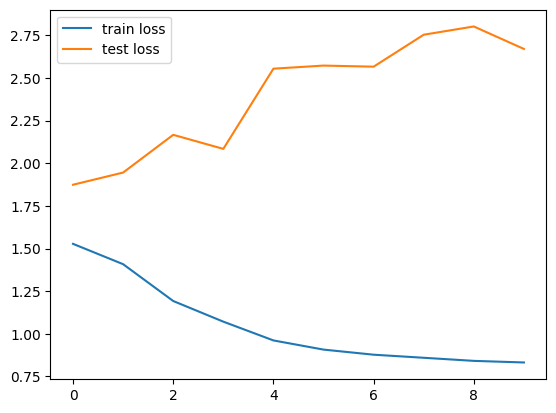

In [11]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

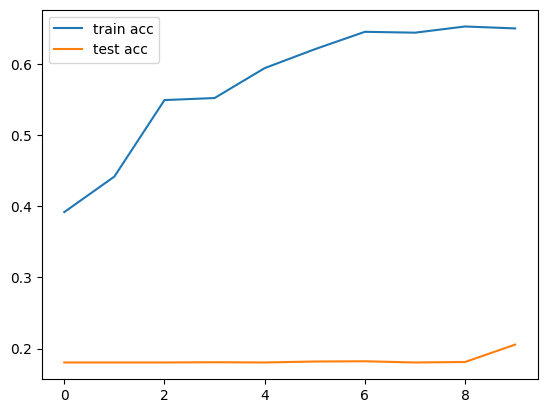

In [12]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend();

In [13]:
best_model = tf.keras.models.load_model('best_rnn_model1.h5')

In [14]:
Ptest = best_model.predict(Xtest)

93/93 [==============================] - 1s 10ms/step


In [15]:
np.mean(np.argmax(Ptest, axis=1) == Ytest.flatten())

0.18052256532066507

In [16]:
from sklearn.preprocessing import StandardScaler

def load_features():
    df = pd.read_csv(
        'UCI-HAR/UCI-HAR-Dataset/train/X_train.txt',
        header=None,
        delim_whitespace=True
    )

    feat_train = df.to_numpy()

    df = pd.read_csv(
        'UCI-HAR/UCI-HAR-Dataset/test/X_test.txt',
        header=None,
        delim_whitespace=True
    )

    feat_test = df.to_numpy()

    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.fit_transform(feat_test)

    return feat_train, feat_test